In [4]:
import pandas as pd
from sqlalchemy import create_engine

# TiDB credentials
username = "3ZpzE69BSNXuvY2.root"
password = "MSiewQGRtx2F7qYu"
host = "gateway01.us-west-2.prod.aws.tidbcloud.com"
port = 4000
database = "stock_analysis"
ssl_certificate_path = "certs/ca-certificate.crt"

# Create connection URL
connection_url = (
    f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}"
    f"?ssl_ca={ssl_certificate_path}"
)

# Create engine
engine = create_engine(connection_url)

# Load data
query = "SELECT * FROM stock_data"
df = pd.read_sql(query, engine)

# Clean and prepare
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(['symbol', 'date'])

# Yearly summary
yearly = df.groupby('symbol').agg(
    start_price=('open', 'first'),
    end_price=('close', 'last'),
    avg_price=('close', 'mean'),
    avg_volume=('volume', 'mean')
).reset_index()

yearly['yearly_return'] = ((yearly['end_price'] - yearly['start_price']) / yearly['start_price']) * 100
yearly['performance'] = yearly['yearly_return'].apply(lambda x: 'Green' if x > 0 else 'Red')

# Top 10 gainers/losers
top_10_gainers = yearly.sort_values('yearly_return', ascending=False).head(10)
top_10_losers = yearly.sort_values('yearly_return').head(10)

# Compute average volume safely
avg_volume = yearly['avg_volume'].mean()
avg_volume = round(avg_volume) if pd.notna(avg_volume) else "N/A"

# Market summary
market_summary = {
    'Green Stocks': (yearly['performance'] == 'Green').sum(),
    'Red Stocks': (yearly['performance'] == 'Red').sum(),
    'Average Price': round(yearly['avg_price'].mean(), 2),
    'Average Volume': avg_volume
}

# Output
print("\n✅ Market Summary:")
print(market_summary)

print("\n📈 Top 10 Gainers:")
print(top_10_gainers[['symbol', 'yearly_return']])

print("\n📉 Top 10 Losers:")
print(top_10_losers[['symbol', 'yearly_return']])



✅ Market Summary:
{'Green Stocks': np.int64(40), 'Red Stocks': np.int64(10), 'Average Price': np.float64(2517.6), 'Average Volume': 7197206}

📈 Top 10 Gainers:
        symbol  yearly_return
47       TRENT     138.708288
8          BEL      89.827644
30         M&M      81.941425
35   POWERGRID      59.314421
5   BAJAJ-AUTO      56.721488
9   BHARTIARTL      54.610837
40   SUNPHARMA      45.598313
38        SBIN      43.924162
45       TECHM      42.439680
39  SHRIRAMFIN      41.511917

📉 Top 10 Losers:
        symbol  yearly_return
24  INDUSINDBK     -32.508452
3   ASIANPAINT     -21.441396
32   NESTLEIND      -7.670122
7   BAJFINANCE      -6.648743
0     ADANIENT      -5.991561
46       TITAN      -5.438697
6   BAJAJFINSV      -4.711310
22  HINDUNILVR      -4.013739
19    HDFCLIFE      -0.842879
11   BRITANNIA      -0.505849


C:\Users\Digital Suppliers\AppData\Local\Temp\ipykernel_12104\528529940.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


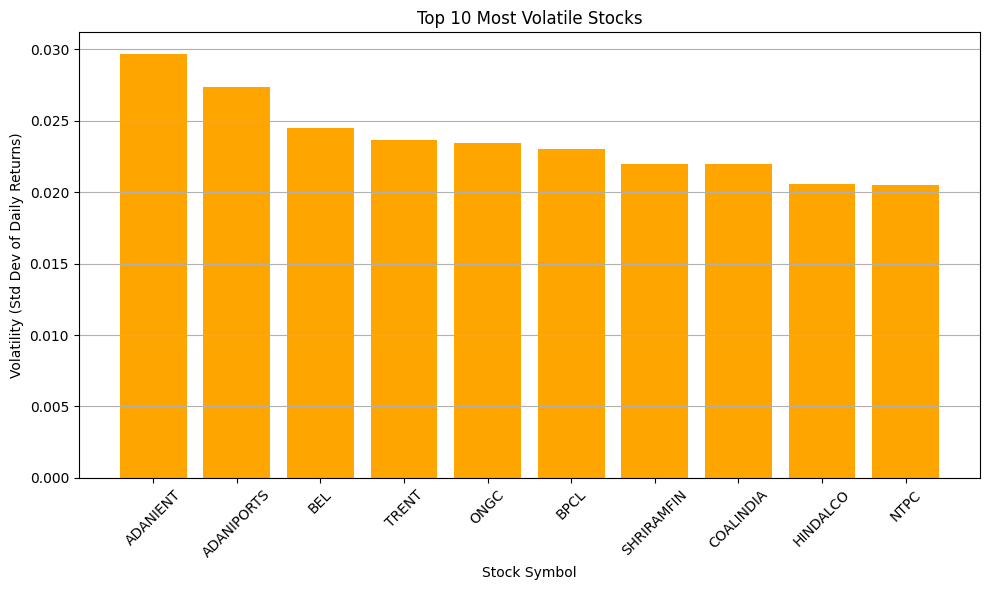

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Step 2: Sort data by symbol and date
df.sort_values(by=['symbol', 'date'], inplace=True)

# Step 3: Calculate daily return for each stock
df['daily_return'] = df.groupby('symbol')['close'].pct_change()

# Step 4: Calculate volatility (standard deviation of daily returns)
volatility = df.groupby('symbol')['daily_return'].std().reset_index()
volatility.columns = ['symbol', 'volatility']
volatility.dropna(inplace=True)

# Step 5: Select top 10 most volatile stocks
top_volatility = volatility.sort_values(by='volatility', ascending=False).head(10)

# Step 6: Plot the volatility
plt.figure(figsize=(10, 6))
plt.bar(top_volatility['symbol'], top_volatility['volatility'], color='orange')
plt.title('Top 10 Most Volatile Stocks')
plt.xlabel('Stock Symbol')
plt.ylabel('Volatility (Std Dev of Daily Returns)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


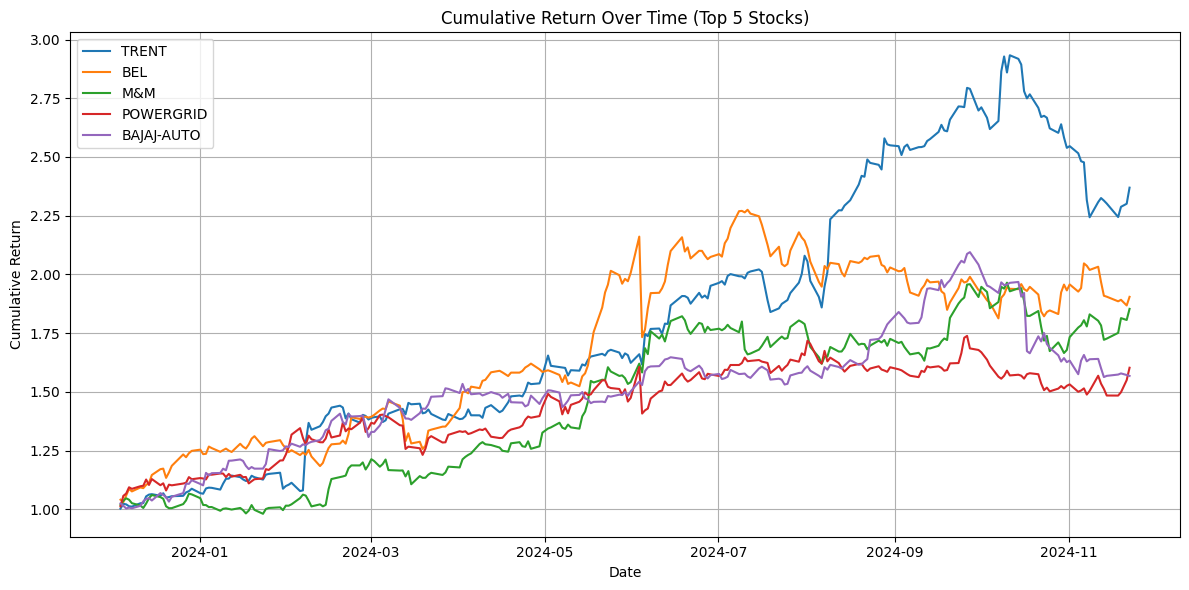

In [16]:
# Step 1: Fetch data (skip connection setup if already done)
df = pd.read_sql("SELECT date, symbol, close FROM stock_data", engine)

# Step 2: Convert date and sort
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d_%H-%M-%S')

df = df.sort_values(['symbol', 'date'])

# Step 3: Calculate daily returns
df['daily_return'] = df.groupby('symbol')['close'].pct_change()

# Step 4: Calculate cumulative return
df['cumulative_return'] = df.groupby('symbol')['daily_return'].transform(lambda x: (1 + x).cumprod())

# Step 5: Get last value of cumulative return for each stock
final_returns = df.groupby('symbol')['cumulative_return'].last().dropna()

# Step 6: Select top 5 performing stocks
top_5_symbols = final_returns.sort_values(ascending=False).head(5).index.tolist()

# Step 7: Plot cumulative return for top 5
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for symbol in top_5_symbols:
    stock_df = df[df['symbol'] == symbol]
    plt.plot(stock_df['date'], stock_df['cumulative_return'], label=symbol)

plt.title("Cumulative Return Over Time (Top 5 Stocks)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


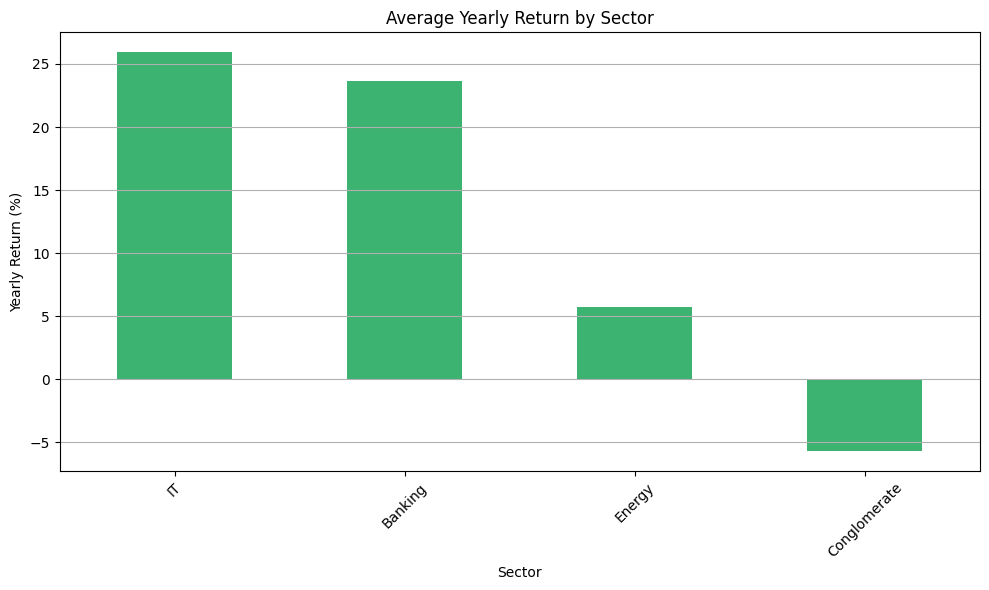

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Sector Mapping (You can update this dictionary as needed)
sector_mapping = {
    'ADANIENT': 'Conglomerate',
    'RELIANCE': 'Energy',
    'INFY': 'IT',
    'TCS': 'IT',
    'HDFCBANK': 'Banking',
    'ICICIBANK': 'Banking',
    # Add more stock-symbol to sector mappings here
}

# Step 2: Map sectors to your stock data
df['sector'] = df['symbol'].map(sector_mapping)

# Step 3: Calculate yearly return for each stock
returns = df.groupby('symbol').agg(
    start_price=('close', 'first'),
    end_price=('close', 'last')
)
returns['yearly_return'] = ((returns['end_price'] - returns['start_price']) / returns['start_price']) * 100

# Step 4: Add sector info to the returns table
returns['sector'] = returns.index.map(sector_mapping)

# Step 5: Calculate average return for each sector
sector_perf = returns.groupby('sector')['yearly_return'].mean().sort_values(ascending=False)

# Step 6: Plot the sector-wise average return
plt.figure(figsize=(10, 6))
sector_perf.plot(kind='bar', color='mediumseagreen')
plt.title('Average Yearly Return by Sector')
plt.xlabel('Sector')
plt.ylabel('Yearly Return (%)')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Digital Suppliers\AppData\Local\Temp\ipykernel_12104\3604231541.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Digital Suppliers\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


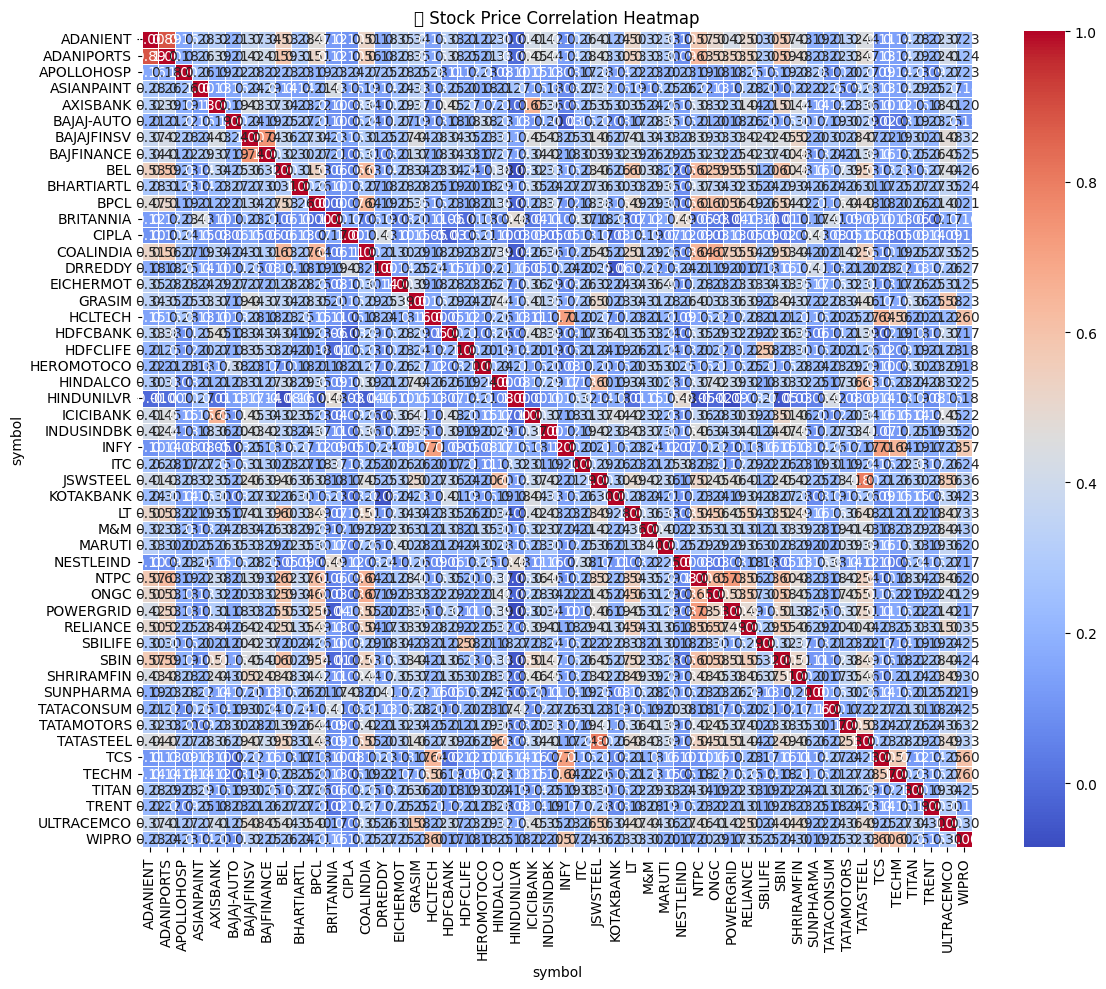

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Load price data from TiDB
df = pd.read_sql("SELECT date, symbol, close FROM stock_data", engine)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d_%H-%M-%S')
df = df.sort_values(['symbol', 'date'])

# ✅ Step 2: Calculate daily returns
df['daily_return'] = df.groupby('symbol')['close'].pct_change()

# ✅ Step 3: Pivot the data to wide format (rows: date, columns: symbol)
pivot_df = df.pivot(index='date', columns='symbol', values='daily_return')

# ✅ Step 4: Compute correlation matrix (between stocks)
correlation_matrix = pivot_df.corr()

# ✅ Step 5: Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("📈 Stock Price Correlation Heatmap")
plt.tight_layout()
plt.show()


C:\Users\Digital Suppliers\AppData\Local\Temp\ipykernel_12104\4076407860.py:38: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Digital Suppliers\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


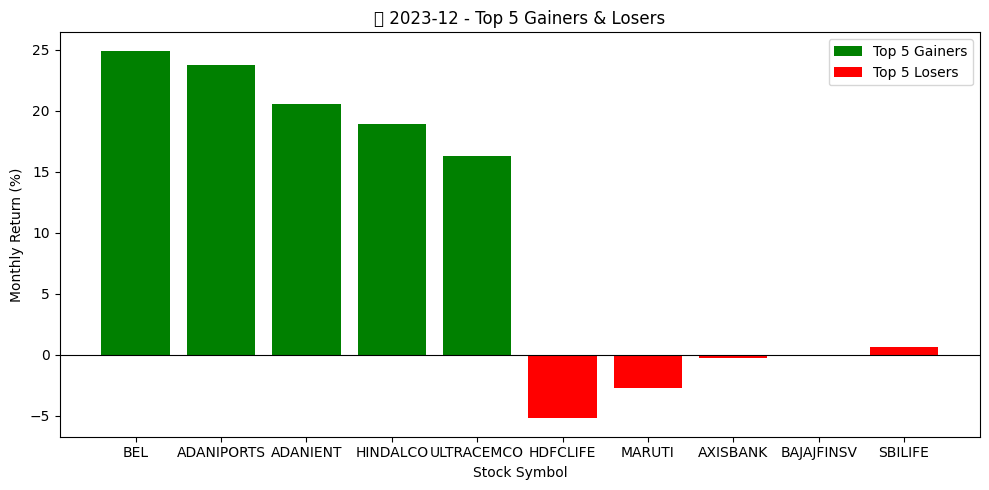

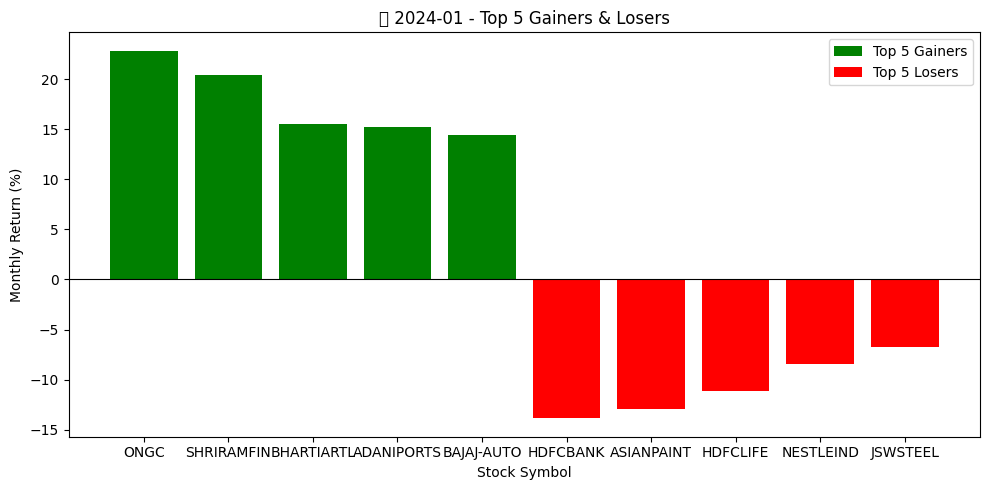

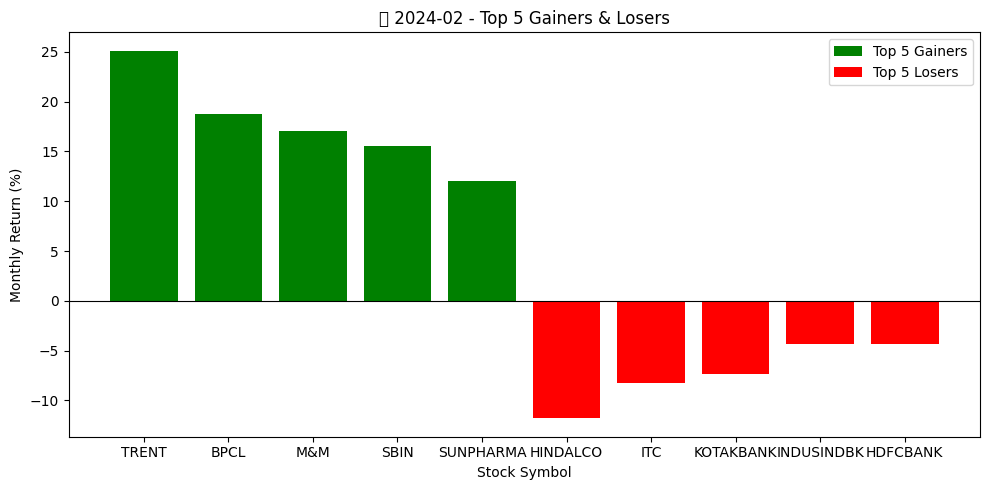

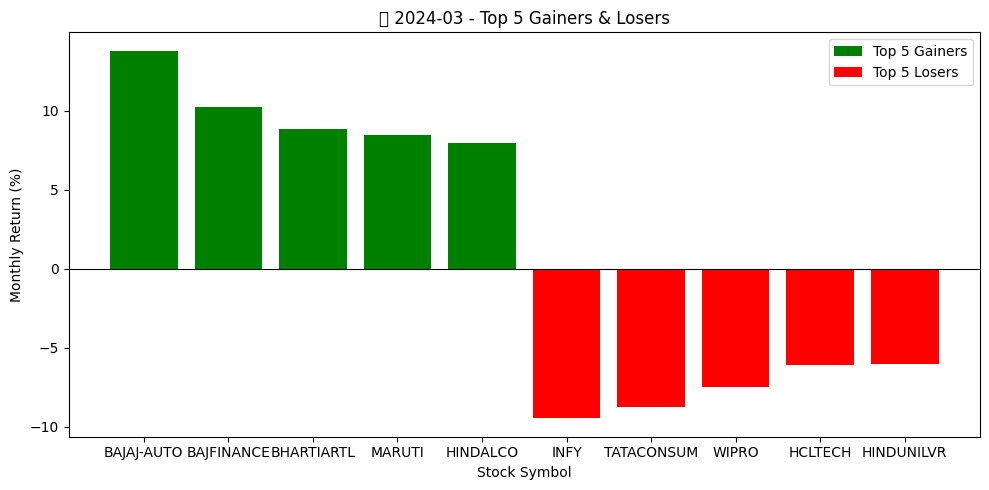

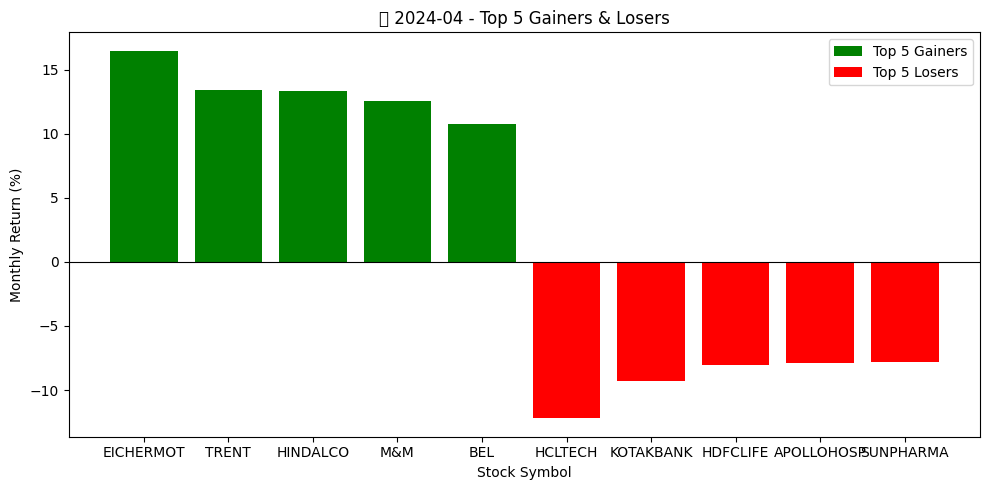

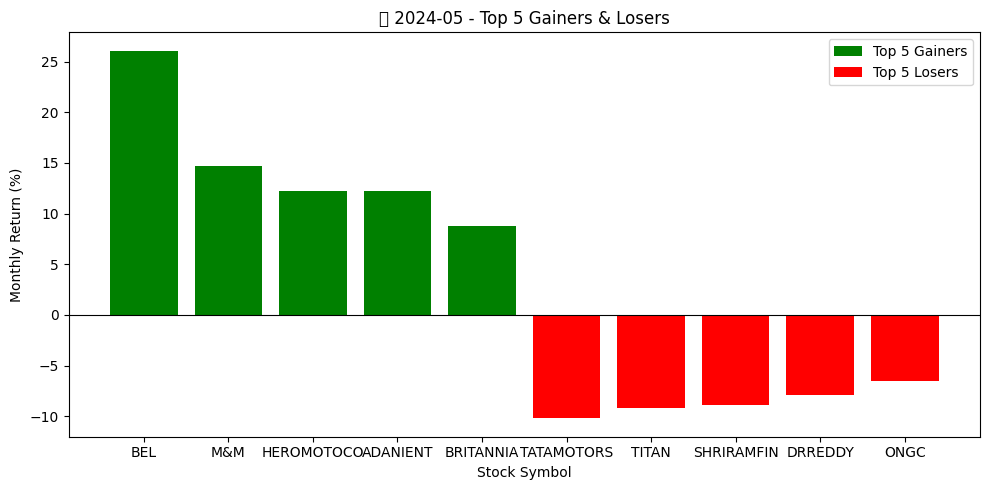

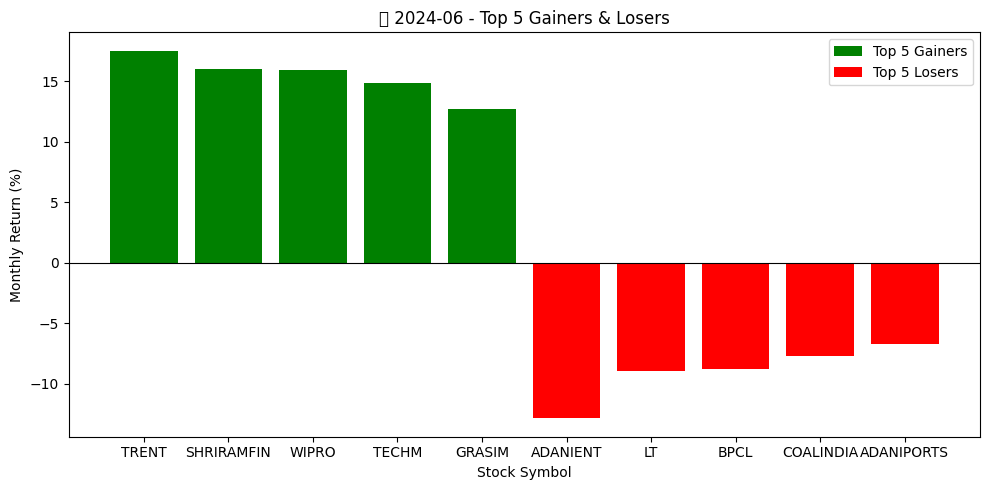

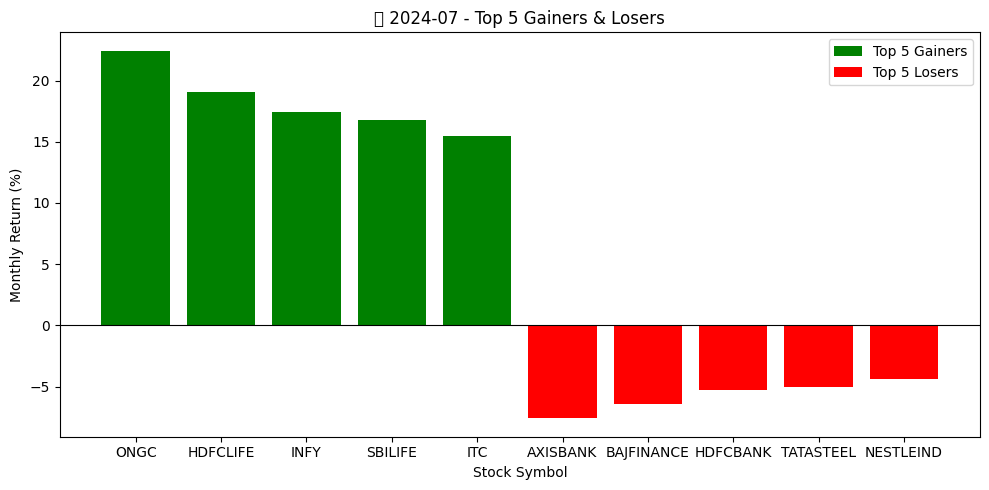

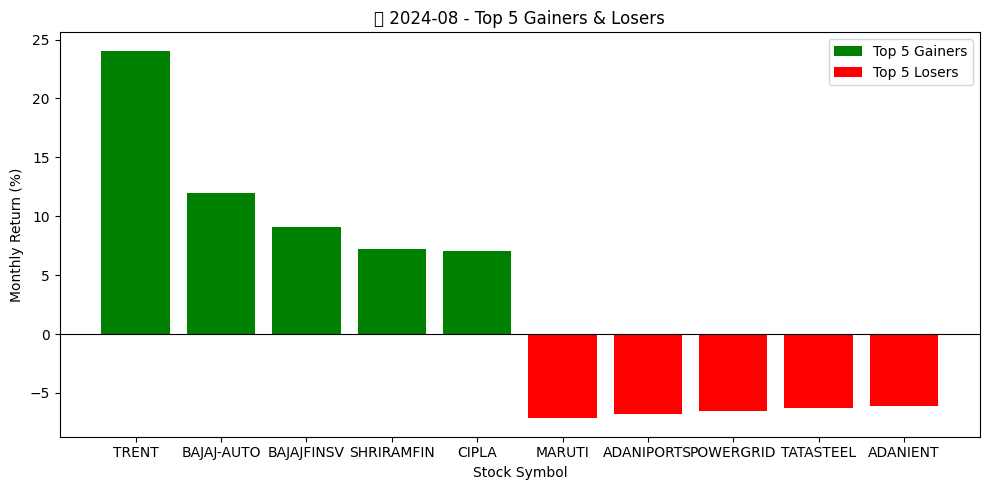

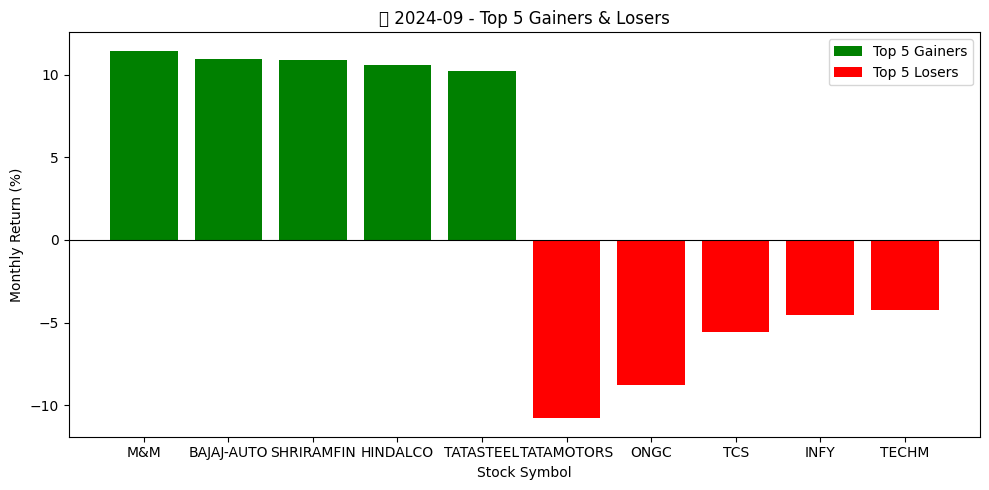

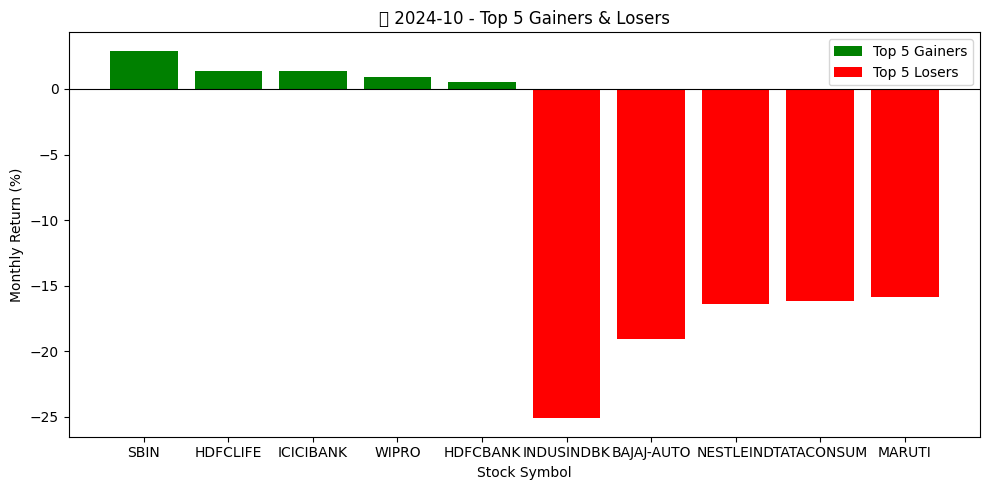

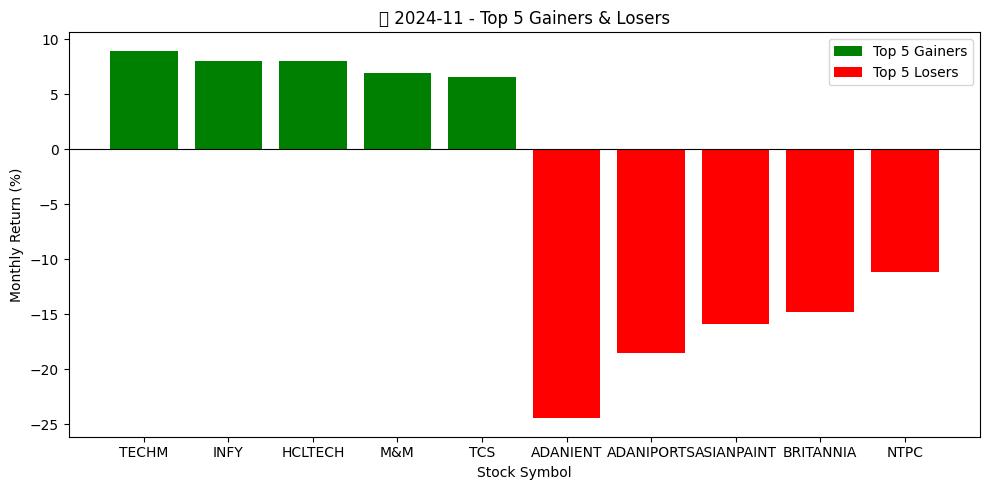

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 1. Load and prepare data
df = pd.read_sql("SELECT date, symbol, close FROM stock_data", engine)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d_%H-%M-%S')
df = df.sort_values(['symbol', 'date'])

# ✅ 2. Add month column
df['month'] = df['date'].dt.to_period('M')

# ✅ 3. Get monthly open and close prices for each stock
monthly = df.groupby(['symbol', 'month']).agg(
    open_price=('close', 'first'),
    close_price=('close', 'last')
).reset_index()

# ✅ 4. Calculate monthly return %
monthly['monthly_return'] = ((monthly['close_price'] - monthly['open_price']) / monthly['open_price']) * 100

# ✅ 5. Plot top 5 gainers and losers for each month
unique_months = monthly['month'].unique()

for m in unique_months:
    month_data = monthly[monthly['month'] == m]
    top_5 = month_data.sort_values('monthly_return', ascending=False).head(5)
    bottom_5 = month_data.sort_values('monthly_return').head(5)

    # 📊 Plot
    plt.figure(figsize=(10, 5))
    plt.bar(top_5['symbol'], top_5['monthly_return'], color='green', label='Top 5 Gainers')
    plt.bar(bottom_5['symbol'], bottom_5['monthly_return'], color='red', label='Top 5 Losers')
    plt.title(f"📅 {m} - Top 5 Gainers & Losers")
    plt.xlabel("Stock Symbol")
    plt.ylabel("Monthly Return (%)")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()
